In [524]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import seaborn as sns

from sklearn import preprocessing, decomposition
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("ar_flare_ml_df.csv")

## get previous day data

In [3]:
data.head()

,AR issue_date,noaa_ar,Carrington Longitude,Area,McIntosh,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,C,M,X,C+,M+,X+
0,2010-01-01 00:30,11039,54.0,130.0,Dai,6.0,8.0,Beta,-28.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-02 00:30,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2.0,0.0,0.0,2.0,0.0,0.0
2,2010-01-03 00:30,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2010-01-04 00:30,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2010-01-05 00:30,11039,52.0,150.0,Dso,7.0,5.0,Beta,-28.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0


In [351]:
len(data)

11885

In [4]:
prev_area, prev_mcint, prev_mag, prev_flare = [], [], [], []
for i in range(len(data)):

    test = data.iloc[i]
    previous_day = (pd.to_datetime(test["AR issue_date"])-datetime.timedelta(days=1)).strftime("%Y-%m-%d 00:30")
    ar_match = test["noaa_ar"]
    data_prev = data[(data["AR issue_date"].isin([previous_day]))&(data["noaa_ar"].isin([ar_match]))]

    if len(data_prev)==0:
        prev_area.append(0), prev_mcint.append(''), prev_mag.append(''), prev_flare.append(0)
    else:
        prev_area.append(data_prev["Area"].values[0]), prev_mcint.append(data_prev["McIntosh"].values[0]), 
        prev_mag.append(data_prev["Mag Type"].values[0]), prev_flare.append(data_prev["C+"].values[0])


In [13]:
data["pre_area"], data["pre_mcint"], data["pre_mag"], data["pre_flare"] = prev_area, prev_mcint, prev_mag, prev_flare

In [14]:
data.head()

,AR issue_date,noaa_ar,Carrington Longitude,Area,McIntosh,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,C,M,X,C+,M+,X+,pre_area,pre_mcint,pre_mag,pre_flare
0,2010-01-01 00:30,11039,54.0,130.0,Dai,6.0,8.0,Beta,-28.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0
1,2010-01-02 00:30,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,2.0,0.0,0.0,2.0,0.0,0.0,130.0,Dai,Beta,0.0
2,2010-01-03 00:30,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,1.0,0.0,0.0,1.0,0.0,0.0,120.0,Dso,Beta,2.0
3,2010-01-04 00:30,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,1.0,0.0,0.0,1.0,0.0,0.0,190.0,Dso,Beta,1.0
4,2010-01-05 00:30,11039,52.0,150.0,Dso,7.0,5.0,Beta,-28.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,Dso,Beta,1.0


In [20]:
data2 = data[data["pre_mcint"]!='']

In [21]:
(data2["McIntosh"] + data2["pre_mcint"]).unique()

array(['DsoDai', 'DsoDso', 'DroDso', 'BxoBxo', 'CriBxo', 'EaoCri',
       'DhcEao', 'EaoDhc', 'EkiEao', 'EkiEki', 'CkiEki', 'DsoCki',
       'DhoDso', 'CaoCso', 'EsoCao', 'EaiEso', 'DsiEai', 'DaiCao',
       'CaiDsi', 'CroDai', 'DsoCai', 'HsxCro', 'CsoDso', 'HsxCso',
       'BxoHsx', 'AxxBxo', 'DsoBxo', 'HsxHsx', 'HaxHsx', 'AxxHax',
       'AxxAxx', 'FkcDkc', 'FkcFkc', 'FaiFkc', 'FsiFai', 'EacDso',
       'FsoFsi', 'EscEac', 'BxoFso', 'CsoEsc', 'CaoCao', 'CroCao',
       'DaoDso', 'DsiDao', 'DsiDsi', 'CsoDsi', 'CsoCso', 'BxoCso',
       'BxoCao', 'CsoBxo', 'CroBxo', 'BxoCro', 'AxxCro', 'EscDao',
       'EsiEsc', 'EaiEsi', 'DaiEai', 'CaiDai', 'BxoCai', 'HsxBxo',
       'AxxHsx', 'CsiBxo', 'BxoCsi', 'DacBxo', 'DhcDac', 'DkiDhc',
       'DhiDki', 'EkiDhi', 'DkiEki', 'HsxHax', 'CkoDhi', 'HaxHax',
       'CaoCko', 'HhxCao', 'CsoHsx', 'HsxHhx', 'CroDro', 'CroCro',
       'CroAxx', 'DroCso', 'BxoAxx', 'BxoDro', 'DaiDai', 'EsiDai',
       'CsoEsi', 'CaoBxo', 'DsiCao', 'DaiBxo', 'DhoDai', 'DsoD

In [22]:
data2.loc[:, "mcevol"] = data2["McIntosh"] + data2["pre_mcint"]

## lets play around with encoding the data

In [456]:
le = preprocessing.LabelEncoder()
data2.loc[:, "mcint_enc"] = le.fit_transform(data2['McIntosh'])
le2 = preprocessing.LabelEncoder()
data2.loc[:,"mcint_evol_enc"] = le2.fit_transform(data2['mcevol'])
le3 = preprocessing.LabelEncoder()
data2.loc[:,"mag_type"] = le3.fit_transform(data2["Mag Type"])

In [457]:
data2[["mag_type", "Mag Type"]]

,mag_type,Mag Type
1,1,Beta
2,1,Beta
3,1,Beta
4,1,Beta
5,1,Beta
...,...,...
11878,1,Beta
11879,1,Beta
11880,1,Beta
11881,1,Beta


In [458]:
data2.head(3)

,AR issue_date,noaa_ar,Carrington Longitude,Area,McIntosh,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude,...,M+,X+,pre_area,pre_mcint,pre_mag,pre_flare,mcevol,mcint_enc,mcint_evol_enc,mag_type
1,2010-01-02 00:30,11039,54.0,120.0,Dso,9.0,6.0,Beta,-27.0,35.0,...,0.0,0.0,130.0,Dai,Beta,0.0,DsoDai,26,491,1
2,2010-01-03 00:30,11039,52.0,190.0,Dso,8.0,12.0,Beta,-28.0,46.0,...,0.0,0.0,120.0,Dso,Beta,2.0,DsoDso,26,502,1
3,2010-01-04 00:30,11039,52.0,220.0,Dso,7.0,10.0,Beta,-29.0,59.0,...,0.0,0.0,190.0,Dso,Beta,1.0,DsoDso,26,502,1


In [459]:
test_db = data2[(data2["AR issue_date"]>"2016-01-01")&(data2["AR issue_date"]<"2017-12-31")]
train_db = data2[~(data2["AR issue_date"]>"2016-01-01")&(data2["AR issue_date"]<"2017-12-31")]

In [460]:
print(np.sum(train_db["C"]!=0)/len(train_db))
print(np.sum(test_db["C"]!=0)/len(test_db))

0.22363847045191193
0.12782608695652173


In [461]:
ind_test = data2.index[(data2["AR issue_date"]>"2016-01-01")&(data2["AR issue_date"]<"2017-12-31")]
ind_train = data2.index[~(data2["AR issue_date"]>"2016-01-01")&(data2["AR issue_date"]<"2017-12-31")]

##  Machine Learning Classification

In [497]:
#columns_to_use = ["mcint_enc", "mcint_evol_enc", "pre_flare", "mag_type", "Area", "Number of Sunspots"]
columns_to_use = ["mcint_enc", "mcint_evol_enc", "pre_flare", "mag_type"]

features = data2[columns_to_use]
features.loc[:, "pre_flare"] = features["pre_flare"].map(lambda x: 1 if x>0 else 0)
labels = data2["C+"].map(lambda x: 1 if x>0 else 0)


In [498]:
features.head(2)

,mcint_enc,mcint_evol_enc,pre_flare,mag_type
1,26,491,0,1
2,26,502,1,1


In [499]:
labels.head()

1    1
2    1
3    1
4    0
5    0
Name: C+, dtype: int64

### Split the data 

In [500]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

In [501]:
# X_train, Y_train = features.loc[ind_train], labels.loc[ind_train]
# X_test, Y_test = features.loc[ind_test], labels.loc[ind_test]
# len(X_test), len(X_train), len(Y_test), len(Y_train), np.sum(Y_test)/len(Y_test), np.sum(Y_train)/len(Y_train)

In [502]:
print("\n", "Train % of flares", 100*np.sum(Y_train)/len(Y_train), "\n",
      "Test % of flares", 100*np.sum(Y_test)/len(Y_test))


 Train % of flares 21.428571428571427 
 Test % of flares 22.21100454316002


In [503]:
mdl = SVC(class_weight="balanced")
mdl = LogisticRegression(class_weight="balanced")
mdl.fit(X_train, Y_train)
pred = mdl.predict(X_test)

In [504]:
def get_tss(Y_test, pred):
    """
    Function to get the Total Skill Score (TSS)
    of 
    """
    
    CM = confusion_matrix(Y_test, pred)
    tn = CM[0][0]
    fn = CM[1][0]
    tp = CM[1][1]
    fp = CM[0][1]
    return (tp/(tp+fn)) - (fp/(fp+tn))

tss = get_tss(Y_test, mdl.predict(X_test))
tss

0.5049775824435137

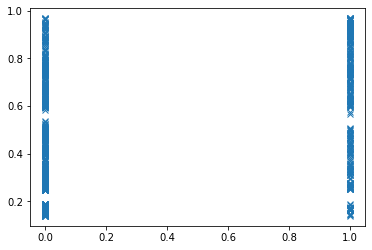

In [505]:
plt.plot(Y_test, mdl.predict_proba(X_test)[:, 1], marker='x',ls='')

<AxesSubplot:ylabel='Density'>

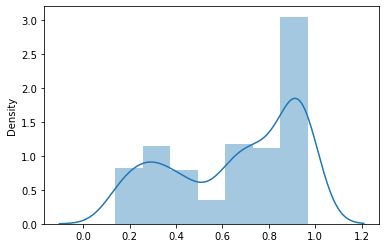

In [506]:
sns.distplot(mdl.predict_proba(X_test)[:, 1][Y_test>0])
#sns.distplot(mdl.predict_proba(X_test)[:, 1][Y_test==0])

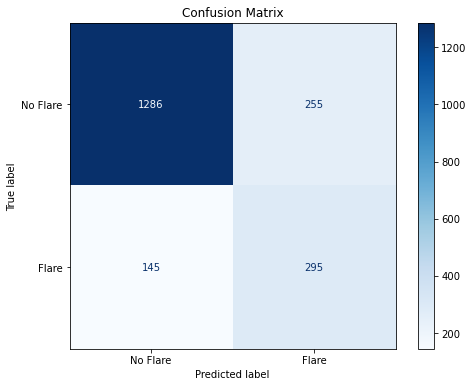

In [507]:
def plot_cm(mdl, X_test, Y_test):
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(mdl, X_test, Y_test, cmap=plt.cm.Blues, ax=ax)#, normalize='true', ax=ax)

    ax.xaxis.set_ticklabels(["No Flare", "Flare"])
    ax.yaxis.set_ticklabels(["No Flare", "Flare"])

    ax.set_title("Confusion Matrix")

plot_cm(mdl, X_test, Y_test)

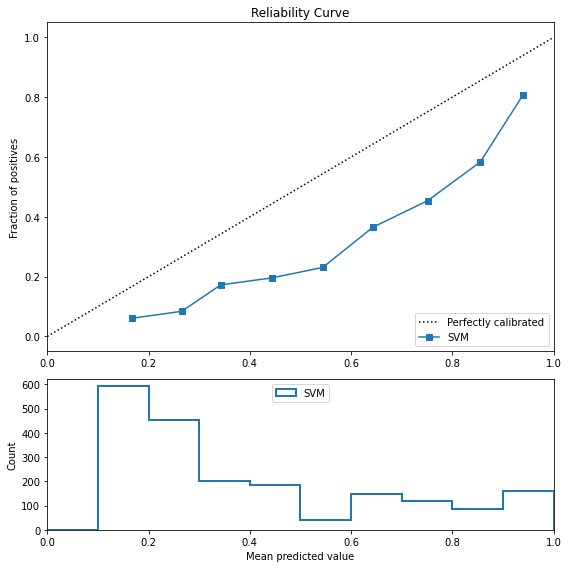

In [508]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")




if hasattr(mdl, "predict_proba"):
    prob_pos = mdl.predict_proba(X_test)[:, 1]
else:  # use decision function
    prob_pos = mdl.decision_function(X_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

clf_score = brier_score_loss(Y_test, prob_pos)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(Y_test, prob_pos, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="SVM")

ax2.hist(prob_pos, range=(0, 1), bins=10, label="SVM",
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curve')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

ax1.set_xlim(0, 1)
plt.tight_layout()

Logistic:
	Brier: 0.123
	Precision: 0.721
	Recall: 0.405
	F1: 0.518

RandomForest:
	Brier: 0.141
	Precision: 0.614
	Recall: 0.427
	F1: 0.504

RandomForest + Isotonic:
	Brier: 0.129
	Precision: 0.704
	Recall: 0.361
	F1: 0.477

RandomForest + Sigmoid:
	Brier: 0.130
	Precision: 0.726
	Recall: 0.355
	F1: 0.476

Logistic:
	Brier: 0.123
	Precision: 0.721
	Recall: 0.405
	F1: 0.518

SVC:
	Brier: 0.199
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

SVC + Isotonic:
	Brier: 0.146
	Precision: 0.597
	Recall: 0.273
	F1: 0.374

SVC + Sigmoid:
	Brier: 0.151
	Precision: 0.606
	Recall: 0.248
	F1: 0.352



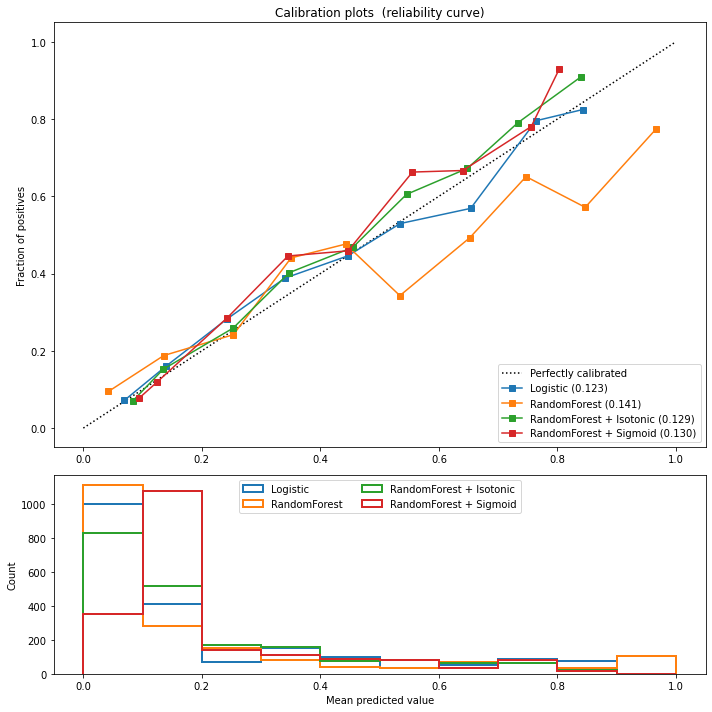

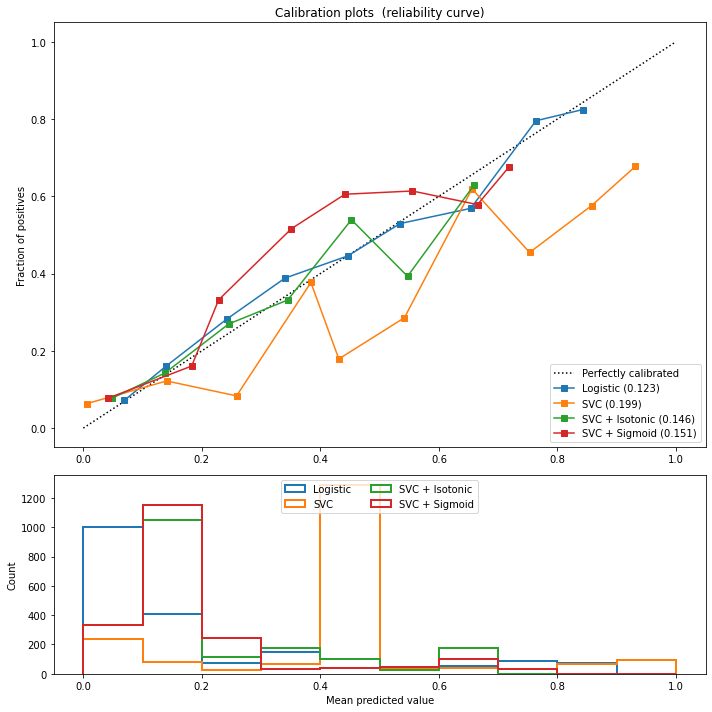

In [521]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(Y_test, prob_pos, pos_label=labels.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(Y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(Y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(RandomForestClassifier(), "RandomForest", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(SVC(), "SVC", 2)

plt.show()

In [515]:
labels.max()

1

In [509]:
y_score = mdl.fit(X_train, Y_train).decision_function(X_test)


fpr, tpr, _ = roc_curve(Y_test, y_score)
roc_auc = auc(fpr, tpr)
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

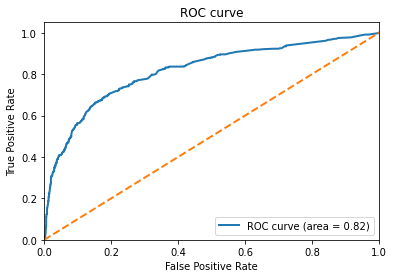

In [510]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [496]:
print("\tBrier: %1.3f" % (clf_score))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

	Brier: 0.123
	Precision: 0.166
	Recall: 0.886
	F1: 0.279



## Compare Several Models

In [430]:
models = []
models.append(('LR', LogisticRegression(class_weight="balanced")))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(class_weight="balanced")))
models.append(('RFC', RandomForestClassifier(class_weight="balanced")))
models.append(('SVM', SVC(class_weight="balanced")))


In [431]:
models[0][1]

LogisticRegression(class_weight='balanced')

In [432]:
tss_vals = []
for name, mdl in models:
    mdl.fit(X_train, Y_train)
    pred = mdl.predict(X_test)
    tss = get_tss(Y_test, pred)
    
    print(name, tss)
    tss_vals.append(tss)
    

LR 0.5241281757546506
KNN 0.35761948513377567
CART 0.30002704007164166
RFC 0.3608861002401624
SVM 0.49441317229468446


In [433]:
mdl = RandomForestClassifier(class_weight="balanced")
mdl.fit(X_train, Y_train)
pred = mdl.predict(X_test)

In [434]:
mdl.feature_importances_

array([0.07213316, 0.23081194, 0.16954209, 0.0705242 , 0.22417863,
       0.23280998])

In [435]:
def plot_feature_importance(mdl, features, top=-1, title="Feature importance"):
    """
    Function to plot the importance of features from a model. 
    
    Parameters
    ----------
    mdl : sklearn model that has been already fit
    features : `pd.DataFrame` of features. 
    top : `int`, optional, number of top features to plot.
          default is to plot all. 
    
    """
    feature_importance = mdl.feature_importances_
    
    sorted_idx = np.argsort(feature_importance)[::-1][0:top]
    np.array(features.columns)[sorted_idx]
    
    pos = np.arange(0, sorted_idx.shape[0]*2, 2)
    
    fig = plt.figure(figsize=(10, 8))
    plt.barh(pos, feature_importance[sorted_idx], 2, align='center')
    plt.gca().invert_yaxis()
    plt.yticks(pos, np.array(features.columns)[sorted_idx])
    plt.title(title)

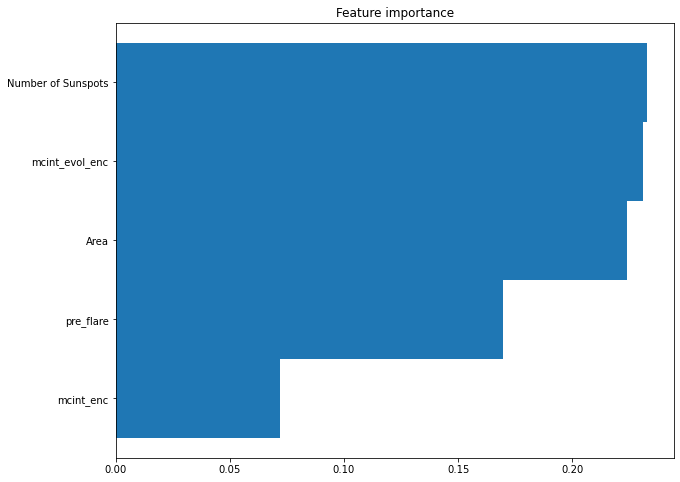

In [436]:
plot_feature_importance(mdl, features)

## PCA analysis

In [601]:
X_train, X_test, y_train, y_test = \
train_test_split(features, labels, test_size=0.2, shuffle=True)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, np.squeeze(y_train.values), np.squeeze(y_test.values)

In [602]:
X_train

array([[ 57, 914,   0,   0],
       [ 15, 279,   0,   1],
       [ 12, 199,   0,   1],
       ...,
       [ 14, 269,   0,   1],
       [ 12, 222,   0,   1],
       [ 23, 436,   0,   1]])

In [613]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=3), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=3), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

In [614]:
# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal components
print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))



Prediction accuracy for the normal test dataset with PCA
78.50%


Prediction accuracy for the standardized test dataset with PCA
79.61%


PC 1 without scaling:
 [ 6.11264611e-02  9.98129962e-01  7.71874423e-05 -3.59114750e-04]

PC 1 with scaling:
 [ 0.69272236  0.68386125 -0.05513975 -0.22232663]


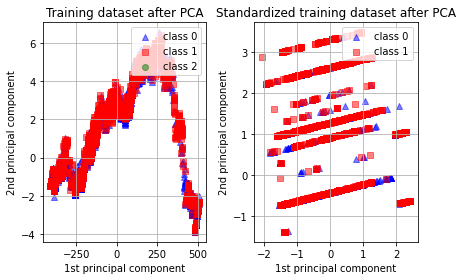

In [615]:
# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

In [616]:
X_train_transformed.shape

(7924, 3)

In [617]:
l=0
X_train_std_transformed[y_train == l, 0]

array([ 2.41618431, -0.53054021, -0.79753855, ..., -0.58512735,
       -0.75004956,  0.06514173])

In [618]:
np.squeeze(y_train)

array([0, 0, 0, ..., 0, 0, 0])